# Relationship to mineral deposits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
import pandas as pd

%matplotlib inline

reconstruction_times = np.arange(0,171)

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [4]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['PbZn-CD', 'PbZn-MVT', 'Cu-sed', 'Magmatic Ni', 'VMS', 'Cu-por', 'IOCG']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation.xls', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

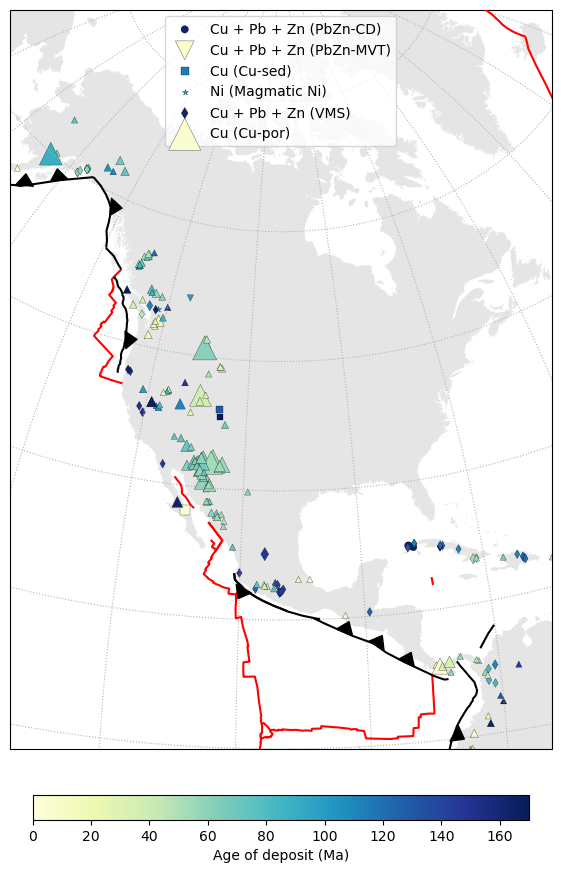

In [5]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.AzimuthalEquidistant(-100, 30))
ax.set_extent([-130, -70, 0, 85])
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, )
gplot.plot_subduction_teeth(ax, color='k', zorder=10, )


for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    sc = ax.scatter(df['Lon'], df['Lat'], s=20+size*8, c=df['Age (Ga)']*1000, marker=symbols[i], cmap='YlGnBu',
                    vmin=0, vmax=reconstruction_times.max(),
                    label=label, transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.2)

    
fig.colorbar(sc, shrink=0.4, pad=0.05, orientation='horizontal', label='Age of deposit (Ma)')
ax.legend(loc='upper center')

Create a `gplately.Points` object for all deposits

In [6]:
pts_dict = dict()

for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]

    pts_dict[sheet] = gplately.Points(model, df['Lon'], df['Lat'])

We want to reconstruct these deposits with an age uncertainty buffer that can be user-defined

In [7]:
from scipy.spatial import cKDTree

def KD_dist(lons0, lats0, lons1, lats1):
    x0, y0, z0 = gplately.tools.lonlat2xyz(lons0, lats0)
    x1, y1, z1 = gplately.tools.lonlat2xyz(lons1, lats1)
    
    tree = cKDTree(np.c_[x0, y0, z0])
    d, idx = tree.query(np.c_[x1, y1, z1])
    return d*gplately.EARTH_RADIUS, idx

def mask_extent(lons, lats, extent):
    mask = np.logical_and(lons > extent[0], lons < extent[1])
    mask[lats < extent[2]] = False
    mask[lats > extent[3]] = False
    return mask

In [8]:
for i, sheet in enumerate(sheets):
    gpts = pts_dict[sheet]
    df = metal_dict[sheet]
    
    print(df.shape)

(3, 16)
(18, 15)
(19, 8)
(1, 12)
(162, 8)
(428, 6)


## Calculate distance between deposit and fracture zone

In [9]:
age_buffer = 10 # Ma

for i, sheet in enumerate(sheets):
    gpts = pts_dict[sheet]
    df = metal_dict[sheet]
    
    # initialise arrays for fracture zones, synthetic seamounts, LIP conjugates
    fz_distances       = np.zeros((df.shape[0], age_buffer))
    fz_magnitude       = np.zeros((df.shape[0], age_buffer))
    seamount_distances = np.zeros((df.shape[0], age_buffer))
    LIP_distances      = np.zeros((df.shape[0], age_buffer)) - 1
    
    for a in range(0, age_buffer):
        ages = np.clip(df['Age (Ga)']*1000 - a, 0, reconstruction_times.max()).astype(int)
        rlons, rlats = gpts.reconstruct_to_birth_age(ages)
        
        # find distance to fracture zones
        with np.load("subducted_fz_data.npz", "r") as npz:
            for i, age in enumerate(ages):
                # extract lon, lat, mag fracture zone data for a given age
                fz_data = npz[str(int(age))]
                fz_lons, fz_lats, fz_mag = fz_data
                if not fz_lons.any():
                    continue

                # find distance between a reconstructed deposit and fracture zones
                dist = gplately.tools.haversine_distance(rlons[i], fz_lons,
                                                         rlats[i], fz_lats,
                                                         degrees=True)
                # find the minimum distance
                idx_dist = dist.argmin()
                fz_distances[i,a] = dist[idx_dist]*1e-3
                fz_magnitude[i,a] = fz_mag[idx_dist]
                
        # find distance to seamounts
        with np.load("subducted_synthetic_seamount_data.npz", "r") as npz:
            for i, age in enumerate(ages):
                # extract lon, lat, mag fracture zone data for a given age
                seamount_lons, seamount_lats = npz[str(int(age))]
                if not seamount_lons.any():
                    continue
                

                # find distance between a reconstructed deposit and fracture zones
                dist = gplately.tools.haversine_distance(rlons[i], seamount_lons,
                                                         rlats[i], seamount_lats,
                                                         degrees=True)
                # find the minimum distance
                idx_dist = dist.argmin()
                seamount_distances[i,a] = dist[idx_dist]*1e-3
        
        # find distance to LIPs
        with np.load("subducted_LIP_data.npz", "r") as npz:
            for i, age in enumerate(ages):
                # extract lon, lat, mag fracture zone data for a given age
                LIP_lons, LIP_lats = npz[str(int(age))]
                if not LIP_lons.any():
                    continue

                # find distance between a reconstructed deposit and fracture zones
                dist = gplately.tools.haversine_distance(rlons[i], LIP_lons,
                                                         rlats[i], LIP_lats,
                                                         degrees=True)
                # find the minimum distance
                idx_dist = dist.argmin()
                LIP_distances[i,a] = dist[idx_dist]*1e-3
        
        
    
    idx_distances = fz_distances.argmin(axis=1)
    rows = range(0, df.shape[0])
    df = df.assign(fz_distance=fz_distances[rows,idx_distances])
    df = df.assign(fz_magnitude=fz_magnitude[rows,idx_distances])
    df = df.assign(seamount_distance=seamount_distances.min(axis=1))
    
    LIP_distance = LIP_distances.min(axis=1)
    LIP_distance[LIP_distance < 0] = np.nan # some LIP distances will be NaNs
    df = df.assign(LIP_distance=LIP_distance)
    
    metal_dict[sheet] = df

## Plot cumulative distributions

In [10]:
from scipy import ndimage

def cdf_distance(dist, size):
    idx_sort = dist.argsort()
    dist = dist[idx_sort].copy()
    size = size[idx_sort].copy()
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    return dist, cumsum_size

def smooth_1D(array, sigma=3, axis=-1):
    return ndimage.gaussian_filter1d(array, sigma, axis=axis)

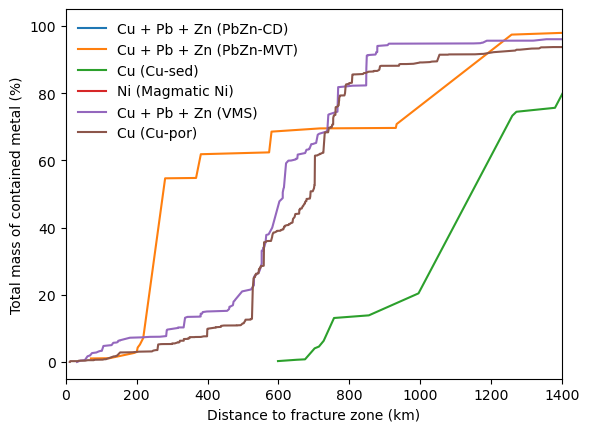

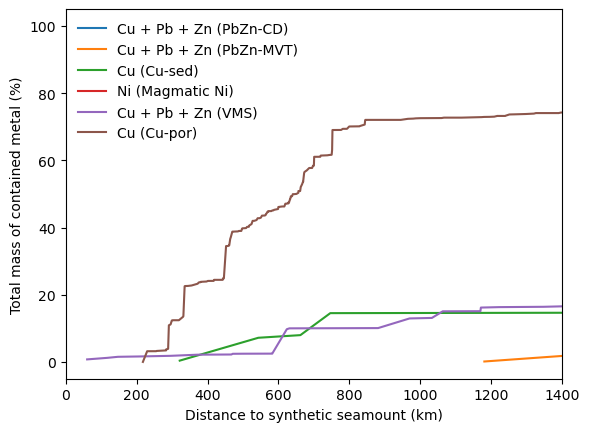

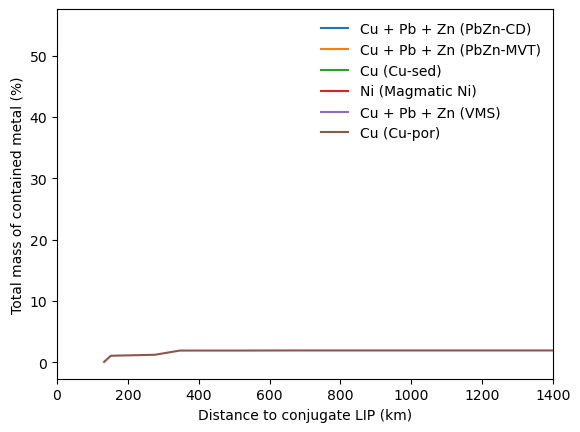

In [11]:
for name, column in [('Distance to fracture zone (km)', 'fz_distance'),
                     ('Distance to synthetic seamount (km)', 'seamount_distance'),
                     ('Distance to conjugate LIP (km)', 'LIP_distance')]:

    fig = plt.figure()
    ax1 = fig.add_subplot(111, xlim=[0,1400])
    ax1.set_xlabel(name)
    ax1.set_ylabel('Total mass of contained metal (%)')

    for sheet in sheets:
        df = metal_dict[sheet]

        # create label for each sheet and add commodities
        label = ""
        size  = np.zeros(df.shape[0])
        for commodity in commodities:
            if commodity in df:
                label += "{} + ".format(commodity[:-5])
                size  += df[commodity].fillna(0.0).to_numpy()
        label = label[:-3] + " ({})".format(sheet)

        cumdist_deposit, cumsize_deposit = cdf_distance(df[column].to_numpy(), size)
        ax1.plot(cumdist_deposit, cumsize_deposit*100, label=label)

    ax1.legend(frameon=False)

Same again, but this time the y axis is just the cumulative probability and not weighted by mass of deposits

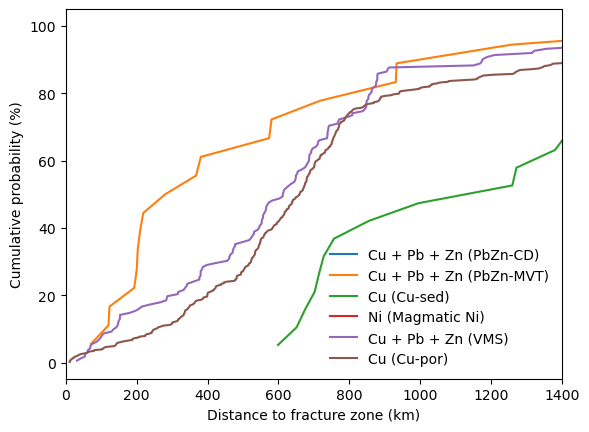

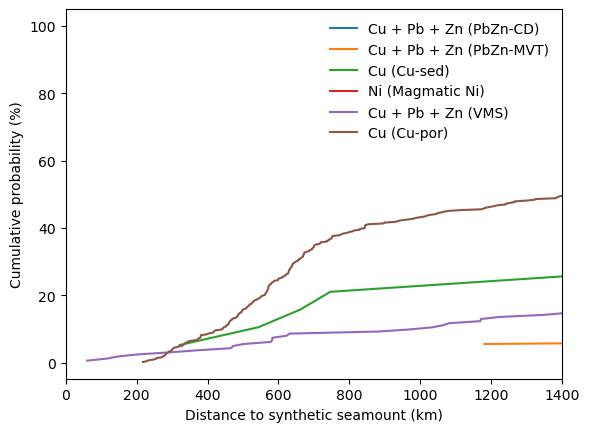

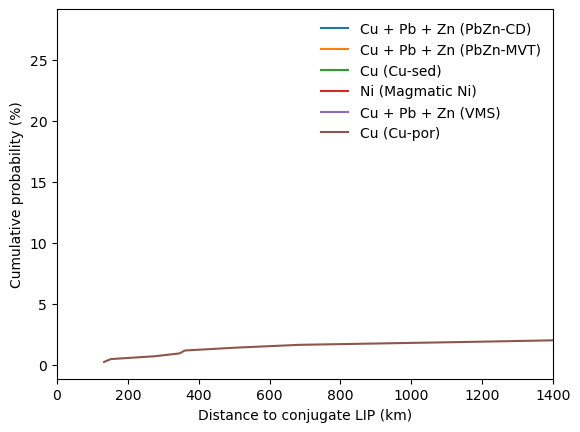

In [12]:
for name, column in [('Distance to fracture zone (km)', 'fz_distance'),
                     ('Distance to synthetic seamount (km)', 'seamount_distance'),
                     ('Distance to conjugate LIP (km)', 'LIP_distance')]:

    fig = plt.figure()
    ax1 = fig.add_subplot(111, xlim=[0,1400])
    ax1.set_xlabel(name)
    ax1.set_ylabel('Cumulative probability (%)')

    for sheet in sheets:
        df = metal_dict[sheet]

        # create label for each sheet and add commodities
        label = ""
        for commodity in commodities:
            if commodity in df:
                label += "{} + ".format(commodity[:-5])
        label = label[:-3] + " ({})".format(sheet)

        cumdist_deposit, cumsize_deposit = cdf_distance(df[column].to_numpy(), np.ones(df.shape[0]))
        ax1.plot(cumdist_deposit, cumsize_deposit*100, label=label)

    ax1.legend(frameon=False)

### Check for any correlation with the "magnitude" of the fracture zone.

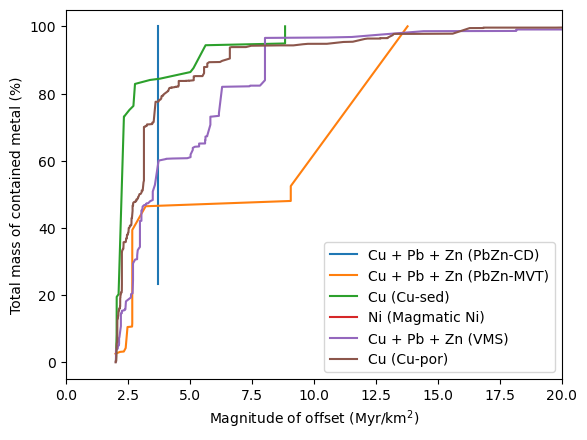

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,20])
ax1.set_xlabel('Magnitude of offset (Myr/km$^2$)')
ax1.set_ylabel('Total mass of contained metal (%)')

for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    mag = df['fz_magnitude'].to_numpy(copy=True)

    # create cumulative distribution
    cumdist_mag, cumsize_mag = cdf_distance(mag, size)
    
    ax1.plot(cumdist_mag, cumsize_mag*100, label=label)

ax1.legend()

## Calculate distance between random deposit and fracture zone

We need to create random "non-deposits" to examine if there is a statistically significant correlation with mineral deposits compared to "non-deposits". We have two options to create "non-deposits":

1. Use Chris Afonso's workflow for determining random "unlabeled" points. This includes a global comparison, but there are definitely some weird clustering going on.
2. Create a new random dataset:
    1. Create a mesh using `stripy` at a similar resolution to the spacing between mineral deposits
    2. Mask out the oceans using the present-day age grid
    3. Trace points back through time to discern whether they are within a distance tolerance of subduction - fracture zone intersections.

In [14]:
df_training = pd.read_csv("../stellar-data-mining/prepared_data/training_data.csv")

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


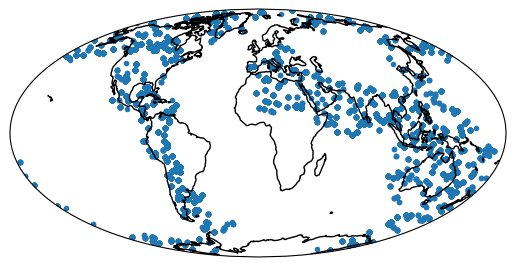

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide())
ax1.coastlines()
ax1.scatter(df_training['lon'][df_training['label']=='unlabelled'],
            df_training['lat'][df_training['label']=='unlabelled'], marker='.', transform=ccrs.PlateCarree())

In [16]:
# create an icosahedral mesh using stripy

import stripy
smesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4, include_face_points=True)

print("Number of points", smesh.npoints)

Number of points 7682


In [17]:
# remove oceans
agegrid = gplately.Raster(agegrid_filename.format(0))
smesh_age = agegrid.interpolate(np.rad2deg(smesh.lons), np.rad2deg(smesh.lats), method='nearest')

continent_lons = np.rad2deg(smesh.lons[np.isnan(smesh_age)])
continent_lats = np.rad2deg(smesh.lats[np.isnan(smesh_age)])

print("Number of continental points", continent_lons.size)

cpts = gplately.Points(model, continent_lons, continent_lats)

Number of continental points 3264


In [49]:
# interpolate to arc
xc, yc, zc = gplately.tools.lonlat2xyz(continent_lons, continent_lats)
tree_continent = cKDTree(np.c_[xc, yc, zc])

mask_arc = np.zeros(continent_lons.size, dtype=bool)
dtol = 125.0/np.tan(np.deg2rad(10))

for reconstruction_time in [0, 10, 20, 30]:
    subduction_data = model.tessellate_subduction_zones(reconstruction_time, ignore_warnings=True)
    rlons, rlats = cpts.reconstruct(reconstruction_time, return_array=True)

    dist_to_sz, idx_sz = KD_dist(subduction_data[:,0], subduction_data[:,1], rlons, rlats)
    mask_arc[dist_to_sz <= dtol] = True
    
# subset points to arc locations
# subset to N and S America?
extent_americas = [-167, -23, -55, 85]
mask_americas = mask_extent(cpts.lons, cpts.lats, extent_americas)

mask_arc_americas = np.logical_and(mask_arc, mask_americas)

arc_pts = gplately.Points(model,
                          continent_lons[mask_arc], 
                          continent_lats[mask_arc])

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


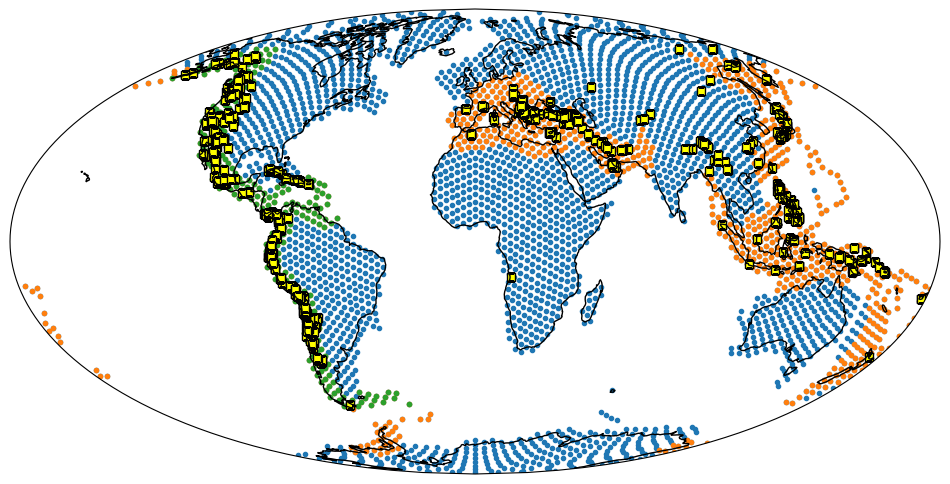

In [50]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide())
ax1.coastlines()
ax1.scatter(continent_lons, continent_lats, marker='.', transform=ccrs.PlateCarree())
ax1.scatter(continent_lons[mask_arc], continent_lats[mask_arc], marker='.', transform=ccrs.PlateCarree())
ax1.scatter(continent_lons[mask_arc_americas], continent_lats[mask_arc_americas],
            marker='.', transform=ccrs.PlateCarree())

for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    sc = ax1.scatter(df['Lon'], df['Lat'], c='yellow', marker='s',
                    vmin=0, vmax=reconstruction_times.max(),
                    label=label, transform=ccrs.PlateCarree(), edgecolor='k', )

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


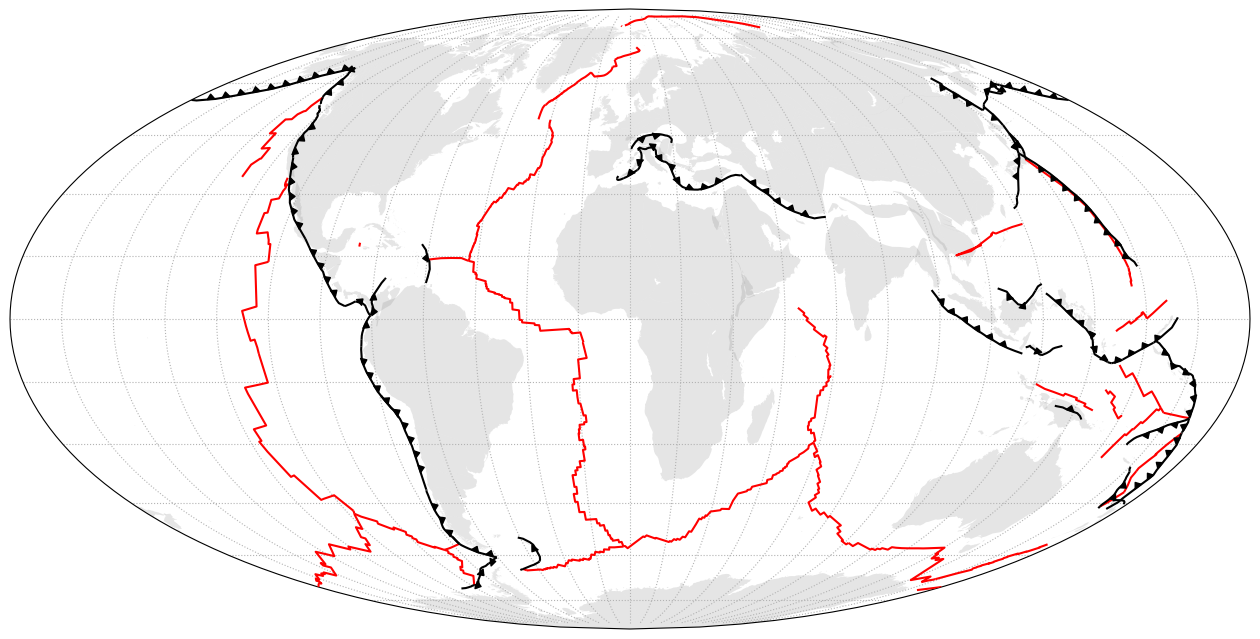

In [51]:
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
ax.set_global()
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 30 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, )
gplot.plot_subduction_teeth(ax, color='k', zorder=10, )

Maybe better to reconstruct each random arc point to find its minimum distance to a subducting fracture zone.

In [63]:
distances_fz_random = np.full(arc_pts.size, 1e99)
distances_sm_random = np.full(arc_pts.size, 1e99)
distances_LIP_random = np.full(arc_pts.size, 1e99)

for t, reconstruction_time in enumerate(reconstruction_times):
    # reconstruct random arc points back through time
    rlons, rlats = arc_pts.reconstruct(int(reconstruction_time), return_array=True)
    
    with np.load("subducted_fz_data.npz", "r") as npz:
        # extract lon, lat, mag fracture zone data for a given age
        fz_lons, fz_lats, fz_mag = npz[str(int(reconstruction_time))]
        dist_to_random, idx_random = KD_dist(fz_lons, fz_lats, rlons, rlats)
        distances_fz_random = np.minimum(distances_fz_random, dist_to_random)
        
    with np.load("subducted_synthetic_seamount_data.npz", "r") as npz:
        # extract lon, lat seamount data for a given age
        seamount_lons, seamount_lats = npz[str(int(reconstruction_time))]
        dist_to_random, idx_random = KD_dist(seamount_lons, seamount_lats, rlons, rlats)
        distances_sm_random = np.minimum(distances_sm_random, dist_to_random)
        
    with np.load("subducted_LIP_data.npz", "r") as npz:
        # extract lon, lat LIP data for a given age
        LIP_lons, LIP_lats = npz[str(int(reconstruction_time))]
        dist_to_random, idx_random = KD_dist(LIP_lons, LIP_lats, rlons, rlats)
        distances_LIP_random = np.minimum(distances_LIP_random, dist_to_random)

distances_fz_random[distances_fz_random == 1e99] = np.nan
distances_sm_random[distances_sm_random == 1e99] = np.nan
distances_LIP_random[distances_LIP_random == 1e99] = np.nan



Text(0.5, 0, 'Distance to LIP (km)')

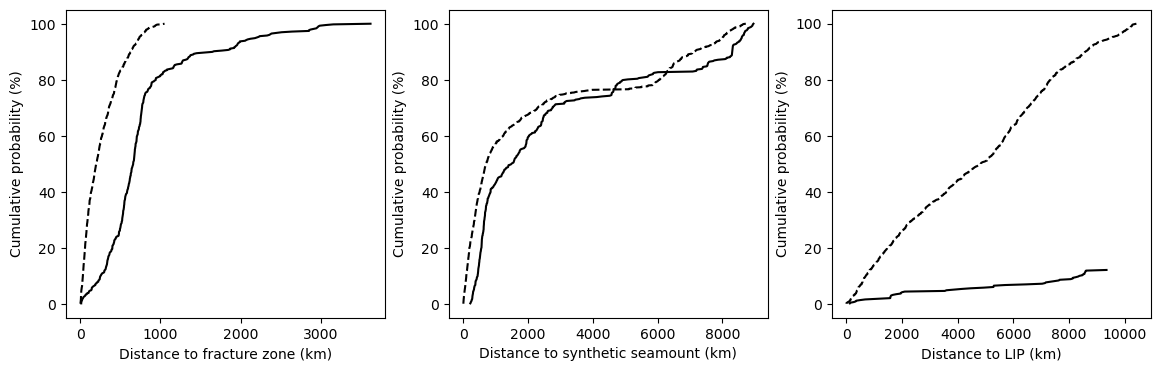

In [62]:
df = metal_dict['Cu-por']

fig, axes = plt.subplots(1,3, figsize=(14,4))

for ax, dist_rand, dist_feat in zip(axes,
                                  [distances_fz_random, distances_sm_random, distances_LIP_random],
                                  [df['fz_distance'], df['seamount_distance'], df['LIP_distance']]):
    
    cumdist_feat, cumsize_feat = cdf_distance(dist_feat.to_numpy(), np.ones_like(dist_feat))
    cumdist_rand, cumsize_rand = cdf_distance(dist_rand, np.ones_like(dist_rand))
    
    ax.plot(cumdist_feat, cumsize_feat*100, 'k', label='Porphyry copper deposits')
    ax.plot(cumdist_rand, cumsize_rand*100, 'k--', label='Random arc locations')
    ax.set_ylabel('Cumulative probability (%)')
    
axes[0].set_xlabel('Distance to fracture zone (km)')
axes[1].set_xlabel('Distance to synthetic seamount (km)')
axes[2].set_xlabel('Distance to LIP (km)')

# ax1.legend(frameon=False)

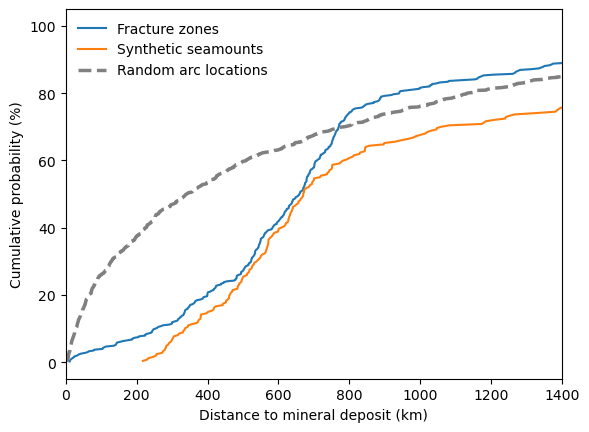

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,1400])
ax1.set_xlabel('Distance to mineral deposit (km)')
ax1.set_ylabel('Cumulative probability (%)')

df = metal_dict['Cu-por']

mask_deposit_americas = mask_extent(df['Lon'], df['Lat'], extent_americas)

distances_fz = df['fz_distance'].to_numpy()
distances_seamounts = df['seamount_distance'].to_numpy()
distances_LIPs = df['LIP_distance'].to_numpy()

cumdist_fz, cumsize_fz = cdf_distance(distances_fz, np.ones_like(distances_fz))
cumdist_LIPs, cumsize_LIPs = cdf_distance(distances_LIPs, np.ones_like(distances_LIPs))
cumdist_random, cumsize_random  = cdf_distance(distances_random, np.ones_like(distances_random))

# NOTE: because Nicky's compilation only includes Pacific seamounts, we must filter to include just the Americas
distances_seamounts = distances_seamounts[mask_deposit_americas]
cumdist_seamounts, cumsize_seamounts = cdf_distance(distances_seamounts, np.ones_like(distances_seamounts))

ax1.plot(cumdist_fz, cumsize_fz*100, label='Fracture zones')
ax1.plot(cumdist_seamounts, cumsize_seamounts*100, label='Synthetic seamounts')
# ax1.plot(cumdist_LIPs, cumsize_LIPs*100, label='Conjugate LIPs')
ax1.plot(cumdist_random,  cumsize_random*100, label='Random arc locations',
         c='0.5', linestyle='--', linewidth=2.5 )
ax1.legend(frameon=False)

Save dataframes to file

In [23]:
with pd.ExcelWriter("data/base_metal_deposit_compilation_processed.xlsx") as writer:
    for sheet in sheets:
        df = metal_dict[sheet]
        df.to_excel(writer, sheet_name=sheet)
        
    # also save random locations to a sheet
    random_data = np.column_stack([
        arc_pts.lons,
        arc_pts.lats,
        distances_random
    ])
    df = pd.DataFrame(random_data, columns=['Lon', 'Lat', 'random_distance'])
    df.to_excel(writer, sheet_name='Random')